In [4]:
import numpy as np

def calculate_force(particle1, particle2):
    dx = particle2[0] - particle1[0]
    dy = particle2[1] - particle1[1]
    r_squared = dx**2 + dy**2
    
    if r_squared == 0:
        return [0, 0]  # Avoid division by zero
    
    force_magnitude = particle1[2] * particle2[2] / r_squared
    force_x = force_magnitude * dx / np.sqrt(r_squared)
    force_y = force_magnitude * dy / np.sqrt(r_squared)
    
    return [force_x, force_y]

def generate_particle_dataset(num_points):
    dataset = []
    
    for _ in range(num_points):
        data_point = []
        positions = set()
        
        # Generate 3 particles with unique positions
        for _ in range(3):
            while True:
                x = np.random.uniform(0, 1)
                y = np.random.uniform(0, 1)
                position = (round(x, 6), round(y, 6))
                
                if position not in positions:
                    positions.add(position)
                    break
            
            mass = np.random.uniform(0.1, 10)
            particle = [x, y, mass, [0, 0]]  # [x, y, mass, [force_x, force_y]]
            data_point.append(particle)
        
        # Calculate forces
        for i in range(3):
            for j in range(3):
                if i != j:
                    force = calculate_force(data_point[i], data_point[j])
                    data_point[i][3][0] += force[0]
                    data_point[i][3][1] += force[1]
        
        dataset.append(data_point)
    
    return dataset

# Generate a dataset with 100 data points
num_points = 100
particle_dataset = generate_particle_dataset(num_points)

# Print the first few data points as an example
for i, data_point in enumerate(particle_dataset[:3]):
    print(f"Data point {i + 1}:")
    for j, particle in enumerate(data_point):
        print(f"  Particle {j + 1}: [x = {particle[0]:.6f}, y = {particle[1]:.6f}, mass = {particle[2]:.4f}, force = [{particle[3][0]:.6e}, {particle[3][1]:.6e}]]")
    print()

Data point 1:
  Particle 1: [x = 0.747947, y = 0.199979, mass = 3.3409, force = [-6.258818e+01, -1.993085e+01]]
  Particle 2: [x = 0.331529, y = 0.002283, mass = 4.7092, force = [7.052590e+01, 3.585154e+01]]
  Particle 3: [x = 0.914720, y = 0.658764, mass = 0.8973, force = [-7.937715e+00, -1.592069e+01]]

Data point 2:
  Particle 1: [x = 0.806149, y = 0.793631, mass = 2.2453, force = [-1.382930e+01, -3.002406e+01]]
  Particle 2: [x = 0.149730, y = 0.457056, mass = 6.1537, force = [2.989777e+01, 1.234213e+01]]
  Particle 3: [x = 0.927804, y = 0.537706, mass = 0.7301, force = [-1.606847e+01, 1.768193e+01]]

Data point 3:
  Particle 1: [x = 0.922996, y = 0.069888, mass = 8.9079, force = [-1.344552e+02, 1.016121e+02]]
  Particle 2: [x = 0.017287, y = 0.129642, mass = 1.6616, force = [3.412512e+01, 6.202113e+00]]
  Particle 3: [x = 0.564304, y = 0.379024, mass = 3.8722, force = [1.003301e+02, -1.078142e+02]]



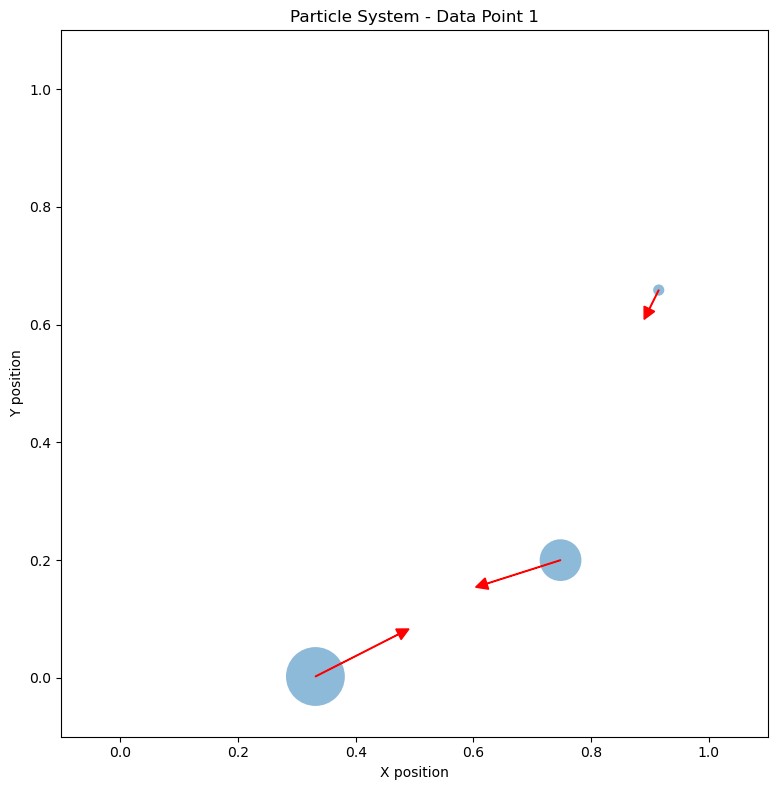

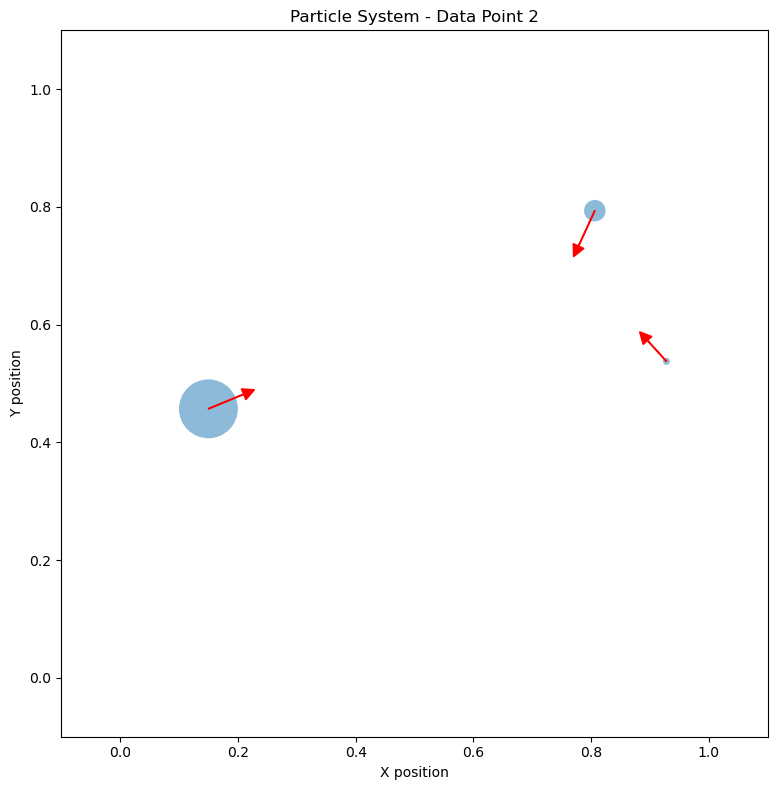

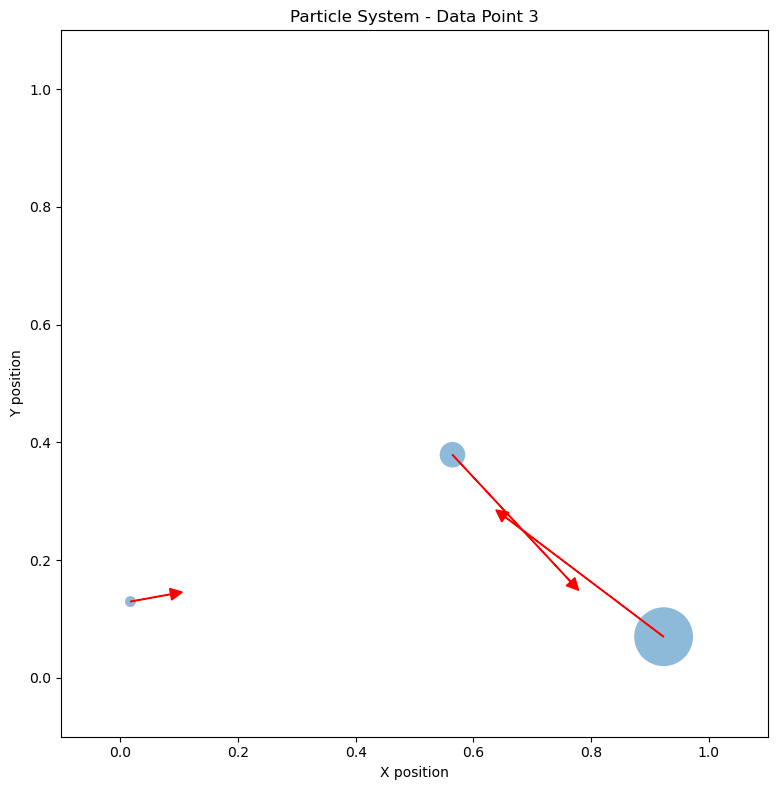

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_particle_system(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        size = 50 * (mass / max_mass)  # Scale size relative to maximum mass
        circle = plt.Circle((x, y), radius=size/1000, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.002
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                    head_width=0.02, head_length=0.02, fc='r', ec='r')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Assuming particle_dataset is already generated
# Plot the first 3 data points
for i, data_point in enumerate(particle_dataset[:3]):
    plot_particle_system(data_point, i+1)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data

class EdgeModel(MessagePassing):
    def __init__(self):
        super(EdgeModel, self).__init__(aggr='add')  # "Add" aggregation.
        self.mlp = nn.Sequential(
            nn.Linear(6, 32),  # 6 = 2 (pos) + 1 (mass) for each particle
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Output 2D force
        )

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j], dim=1)  # Concatenate features of both nodes
        return self.mlp(tmp)

class NodeModel(nn.Module):
    def __init__(self):
        super(NodeModel, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(5, 32),  # 5 = 2 (pos) + 1 (mass) + 2 (aggregated force)
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Output 2D force
        )

    def forward(self, x, edge_index, edge_attr):
        row, col = edge_index
        agg = edge_attr.sum(dim=0)  # Sum the forces from connected edges
        out = torch.cat([x, agg.unsqueeze(0)], dim=1)
        return self.mlp(out)

class ParticleGNN(nn.Module):
    def __init__(self):
        super(ParticleGNN, self).__init__()
        self.edge_model = EdgeModel()
        self.node_model = NodeModel()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Edge Model
        edge_attr = self.edge_model(x, edge_index)
        
        # Node Model
        out = self.node_model(x, edge_index, edge_attr)
        
        return out

# Create a sample input
def create_sample_data(num_particles=3):
    x = torch.rand(num_particles, 3)  # [x, y, mass] for each particle
    edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                               [1, 2, 0, 2, 0, 1]], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index)
    return data

# Initialize the model
model = ParticleGNN()

# Create sample data
data = create_sample_data()
print(data)

# Forward pass
output = model(data)

print("Input:")
print(data.x)
print("\nOutput (forces):")
print(output)

Data(x=[3, 3], edge_index=[2, 6])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 3 but got size 1 for tensor number 1 in the list.